In [1]:
import sys
sys.path.insert(1, '../')

from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             roc_curve, precision_recall_curve, confusion_matrix, 
                             ConfusionMatrixDisplay)

# **TEXT PHISHING DETECTION** 

* * *

## Dataset

The following dataset combines SMS and Emails datasets for phishing detection. It is balanced and already preproccessed for text analysis

In [2]:
df = pd.read_csv('../DATASETS/PRE/TEXTS.csv')
df

,text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1
...,...,...
20132,You have won a Nokia 7250i. This is what you g...,1
20133,Get ur 1st RINGTONE FREE NOW! Reply to this ms...,1
20134,Ur cash-balance is currently 500 pounds - to m...,1
20135,Records indicate you were involved in an accid...,1


Splitting datasets in training and test sets

In [3]:
X = df['text']
y = df['label']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y)

## TF-IDF Vectorizer

TF-IDF vectorizer is a technique for transforming text into numerical vectors that can be used for machine learning or other purposes. It stands for Term Frequency-Inverse Document Frequency, which means that it assigns a weight to each word based on how often it appears in a document and how rare it is across a collection of documents. The purpose of TF-IDF vectorizer is to measure the importance or relevance of a word in a document, and to reduce the impact of common words that do not carry much information. For example, the word "the" is very frequent in English, but it does not tell us much about the topic or meaning of a text. Therefore, TF-IDF vectorizer would give it a low weight compared to a word like "vectorizer", which is less common and more specific.

TF-IDF vectorizer can create features that represent the content and tone of a text, and feed them into a classifier algorithm such as logistic regression, naive Bayes, or support vector machines.

### Hyperparameter optimization with GridSearchCV

GridSearchCV is a cross validation technique included in the scikit learn package. What it does is to run through the different parameters entered in the parameter grid and extract the best values and parameter combinations. Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters. This makes the processing time-consuming and expensive based on the number of hyperparameters involved. Along with Grid Search, cross-validation is also performed.

Some of the hyperparameters of TfidfVectorizer that can be optimized with Bayes search are:

- **max_df**: This parameter controls the maximum document frequency for a term to be included in the vocabulary. It can be a fraction between 0 and 1, or an integer representing the absolute count. A lower value of max_df can reduce the noise and dimensionality of the feature matrix by filtering out common terms.

- **ngram_range**: This parameter specifies the range of n-values for different n-grams to be extracted from the text. An n-gram is a sequence of n consecutive words or characters in a text. A larger value of n can capture more information about the word order and context, but it can also increase the number and size of the features.

In [4]:
# Define the Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True)

In [5]:
# Define the vectorizer
vect = TfidfVectorizer(stop_words="english")

# Define multinomial naive bayes classifier
mnb = MultinomialNB()

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', vect), 
    ("mnb", mnb)
])

# Define the parameter search
params = {
    'tfidf__max_df': (0.25, 0.5, 0.75, 1),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'mnb__alpha': (1, 0.1, 0.01)
}

# Perform the bayesian search
gs = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    cv=skf, 
    scoring='recall', 
    n_jobs=4
)

gs.fit(xtrain, ytrain)

# Print the best parameters and best score
print("BEST PARAMETERS:")
pprint(gs.best_params_, indent=2)
print(f"\nBEST SCORE: {gs.best_score_:.3f}")

/opt/anaconda3/envs/machine_learning/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


BEST PARAMETERS:
{'mnb__alpha': 0.01, 'tfidf__max_df': 0.25, 'tfidf__ngram_range': (1, 2)}

BEST SCORE: 0.964


In [6]:
# Print best estimators for TF-IDF Vect & Multinomial NB
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.01))])

## Multinomial Naive Bayes Classifier

A multinomial naive bayes classifier is a type of naive bayes classifier that assumes that the features are multinomially distributed. This means that each feature can take one of a finite number of possible values, such as the count or frequency of a word in a document. A multinomial naive bayes classifier is suitable for text classification problems, where the goal is to assign a document to one or more predefined categories based on its content. For example, a multinomial naive bayes classifier can be used to classify news articles into topics such as sports, politics, entertainment, etc.

The purpose of a multinomial naive bayes classifier is to use the Bayes’ theorem to calculate the probability of each category given the features of a document, and then choose the category with the highest probability as the prediction. The Bayes’ theorem states that the posterior probability of a category given the features is proportional to the prior probability of the category multiplied by the likelihood of the features given the category. The naive assumption is that the features are conditionally independent of each other given the category, which simplifies the calculation of the likelihood.

In [7]:
# Create TF-IDF Vectorizer with best hyperparameters found
vect = TfidfVectorizer(ngram_range=(1, 2), max_df=0.25, stop_words='english')
# Create Multinomial NB Classifier with best hyperparameters found
mnb = MultinomialNB(alpha=0.01)

In [8]:
# get tf-idf matrix for training
train_vect_matrix = vect.fit_transform(xtrain)
# transform X_test to tf-idf matrix
test_vect_matrix = vect.transform(xtest)
# fit NB classifier with the matrix
mnb.fit(train_vect_matrix, ytrain)

MultinomialNB(alpha=0.01)

Naive Bayes Classifier gives us the following performance evaluation on the test set:

In [25]:
# Predict and evaluate NB classifier
y_pred = mnb.predict(test_vect_matrix)
y_pred_proba = mnb.predict_proba(test_vect_matrix)[:, 1]
print("\n#### RESULTS:")
print(f"Accuracy: {accuracy_score(ytest, y_pred):.5f}")
print(f"Precision: {precision_score(ytest, y_pred):.5f}")
print(f"Recall: {recall_score(ytest, y_pred):.5f}")
print(f"F1-score: {f1_score(ytest, y_pred):.5f}")


#### RESULTS:
Accuracy: 0.97815
Precision: 0.97319
Recall: 0.96938
F1-score: 0.97128


Also, we are going to visualize classifier performance through this plots:

- ROC-AUC curve 
- Precision-Recall curve
- Confusion matrix

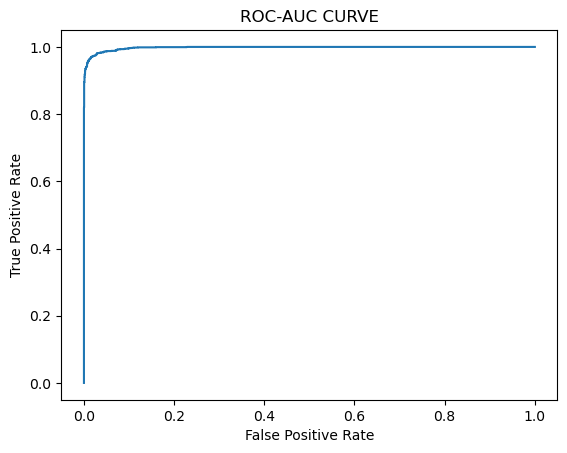

In [10]:
fpr, tpr, _ = roc_curve(ytest,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.title('ROC-AUC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

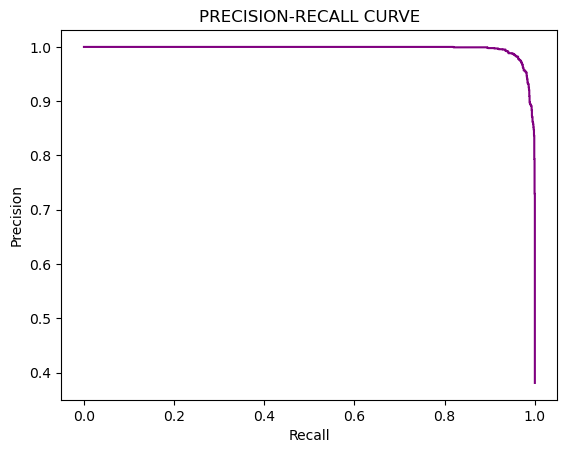

In [11]:
precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
#create Precision-Recall curve
plt.plot(recall, precision, color='purple')
plt.title('PRECISION-RECALL CURVE')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

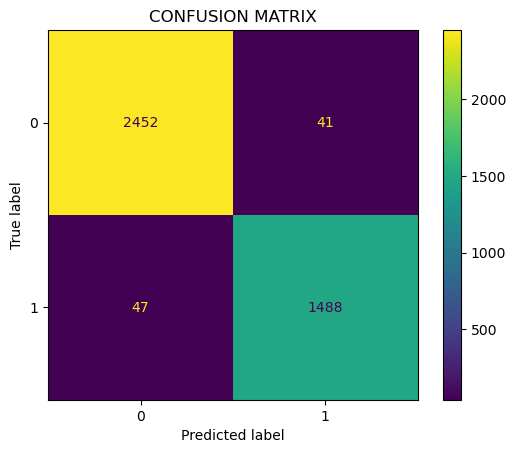

In [12]:
cm = confusion_matrix(ytest, y_pred, labels=mnb.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb.classes_)
cm_display.plot()
plt.title('CONFUSION MATRIX')
plt.show()

#### Words Probabilities Analysis

We can extract the probability of each word being classified as phishing or not using `feature_log_prob` function from NB classifier. This gives us a matrix of shape `(n_classes, n_words)`, where class $1$ is phishing and $0$ is benign. Also, TF-IDF vectorizer gives us the features (or words) names it extracted from the train texts.

In [13]:
# Get feature probabilities
class_prob = np.exp(mnb.feature_log_prob_)
# Get feature names, or simply get words
feature_names = vect.get_feature_names_out()

With this information we can plot the top 10 words that have higher probabilities of being classified as phishing or benign. The results will tell us which words are more related with each classification class

In [14]:
benign_prob = class_prob[0] # 0 is for benign
benign_index = np.argsort(benign_prob)[-10:]
benign_words = [feature_names[i] for i in benign_index]
benign_values = [benign_prob[i] for i in benign_index]

phishing_prob = class_prob[1] # 1 is for phishing
phishing_index = np.argsort(phishing_prob)[-10:]
phishing_words = [feature_names[i] for i in phishing_index]
phishing_values = [phishing_prob[i] for i in phishing_index]

In [15]:
pd.Series(data=benign_values, index=benign_words)

2002        0.000553
language    0.000559
hou         0.000560
net         0.000561
http www    0.000595
www         0.000646
list        0.000668
linux       0.000832
ect         0.001152
enron       0.001284
dtype: float64

In [16]:
pd.Series(data=phishing_values, index=phishing_words)

just        0.000511
new         0.000545
business    0.000553
www         0.000563
company     0.000565
000         0.000608
money       0.000652
email       0.000809
click       0.000879
free        0.000979
dtype: float64

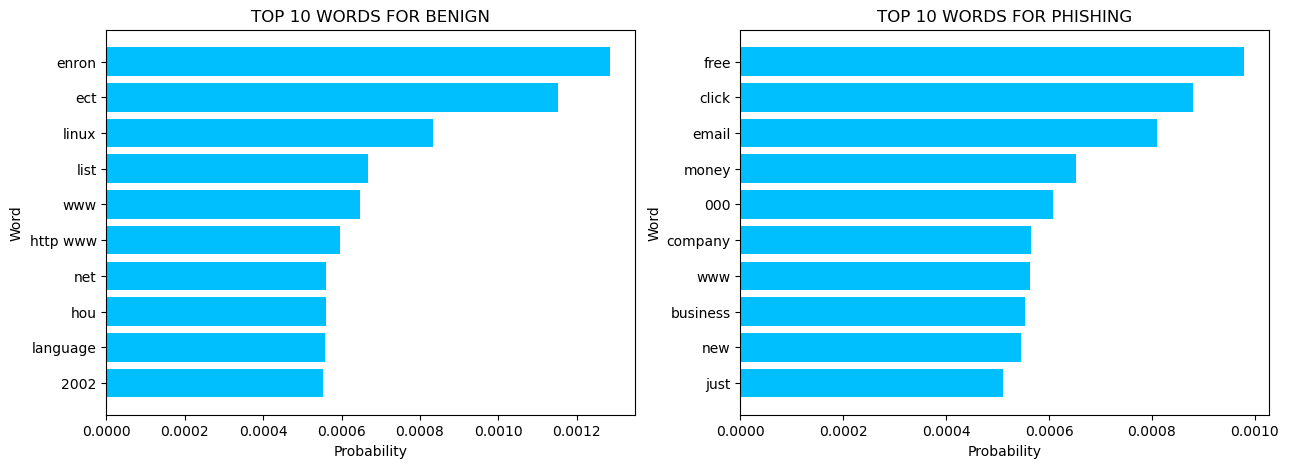

In [17]:
# Plot top 10 words for phishing and benign classification
plt.figure(figsize=(15, 5)) 

plt.subplot(1, 2, 1) 
plt.barh(benign_words, benign_values, color='deepskyblue')
plt.xlabel("Probability")
plt.ylabel("Word")
plt.title('TOP 10 WORDS FOR BENIGN')

plt.subplot(1, 2, 2)
plt.barh(phishing_words, phishing_values, color='deepskyblue')
plt.xlabel("Probability")
plt.ylabel("Word")
plt.title('TOP 10 WORDS FOR PHISHING')

plt.show()

For a nicer visualization of this graphs we can use WordCloud library to create, precisely, a wordcloud, where the most probable words of being classified as phishing or benign are bigger than the others.

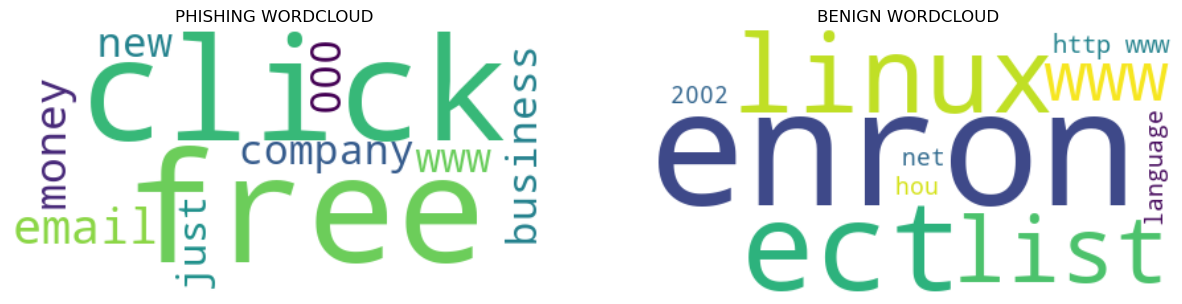

In [18]:
phishing_dict = dict(zip(phishing_words, phishing_values))
benign_dict = dict(zip(benign_words, benign_values))
phishing_cloud = WordCloud(background_color="white").generate_from_frequencies(phishing_dict)
benign_cloud = WordCloud(background_color="white").generate_from_frequencies(benign_dict)

plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1) # Go to the first subplot
plt.imshow(phishing_cloud, interpolation="bilinear")
plt.title('PHISHING WORDCLOUD')
plt.axis('off') 

plt.subplot(1, 2, 2) # Go to the second subplot
plt.imshow(benign_cloud, interpolation="bilinear") 
plt.title('BENIGN WORDCLOUD')
plt.axis('off') 

plt.show() 

#### TF-IDF Analysis

**TF-IDF (term frequency-inverse document frequency)** is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. The higher is the value, the more relevant the term is in that document. Hence, we'll check TF-IDF averages scores of all features extracted from TF-IDF Vectorizer and sort them in descending order, so we can know which are the most relevant words over all texts corpus.

In [19]:
# Get TF-IDF averages scores from all features
tfidfs = pd.DataFrame.sparse.from_spmatrix(train_vect_matrix, columns=vect.get_feature_names_out())

In [20]:
# Sort in descending order TF-IDF Averages, and get the 25 first values
tfidf_avgs = tfidfs.mean(axis=0).sort_values(ascending=False)[:25]
tfidf_avgs

enron          0.009902
ect            0.008895
www            0.007753
list           0.007003
linux          0.006992
http www       0.006765
email          0.006360
net            0.006294
free           0.006232
new            0.006175
00             0.005994
click          0.005826
just           0.005759
information    0.005652
mail           0.005583
time           0.005545
10             0.005351
like           0.005300
know           0.005116
000            0.005028
message        0.004868
2002           0.004773
subject        0.004553
date           0.004452
need           0.004414
dtype: Sparse[float64, 0]

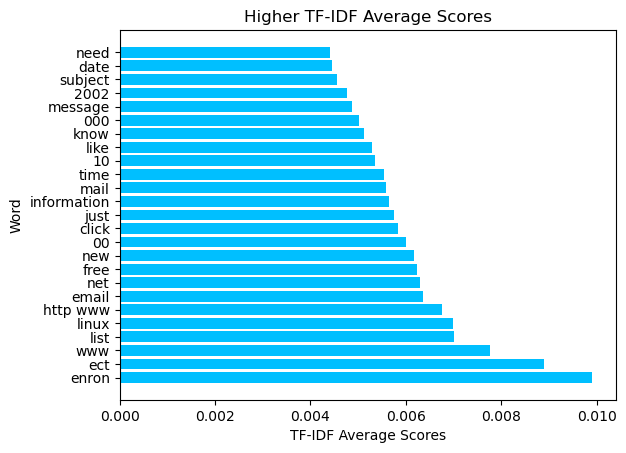

In [21]:
plt.barh(tfidf_avgs.index, tfidf_avgs.values, color='deepskyblue')
plt.xlabel("TF-IDF Average Scores")
plt.ylabel("Word")
plt.title('Higher TF-IDF Average Scores')

plt.show()

**IDF** is a measure of how common or rare a term is across the entire corpus of documents (texts samples). If the word is common and appears in many documents, the idf value (normalized) will approach 0 or else approach 1 if it’s rare. Hence, let's see which are the most common words across all texts samples using this measure.

In [22]:
idfs = vect.idf_ * (1/vect.idf_.max()) # normalize idfs vector between 0 to 1
lower_idfs_indexes = np.argsort(idfs)[:25]
most_common_words = [feature_names[i] for i in lower_idfs_indexes]
most_common_words_idfs = [idfs[i] for i in lower_idfs_indexes]

In [23]:
pd.Series(data=most_common_words_idfs, index=most_common_words)

www            0.248154
time           0.256161
new            0.256933
information    0.257500
list           0.262917
http www       0.264768
like           0.264962
just           0.265707
email          0.270060
subject        0.274718
10             0.275432
know           0.277533
mail           0.280844
message        0.289204
use            0.291829
need           0.292592
free           0.296939
make           0.297697
net            0.303124
thanks         0.303314
2002           0.306099
work           0.309718
send           0.311244
want           0.312794
sent           0.312950
dtype: float64

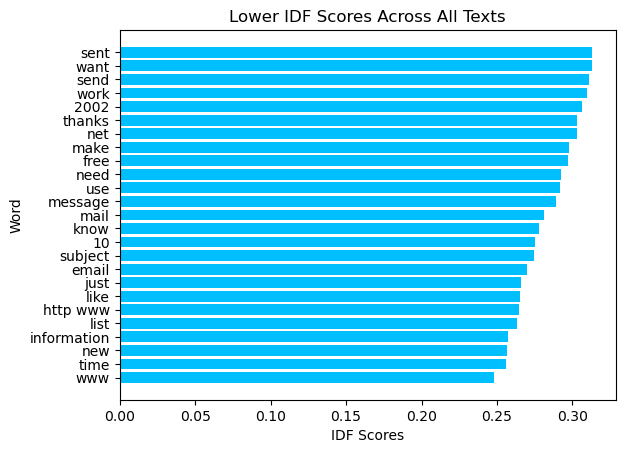

In [24]:
plt.barh(most_common_words, most_common_words_idfs, color='deepskyblue')
plt.xlabel("IDF Scores")
plt.ylabel("Word")
plt.title('Lower IDF Scores Across All Texts')

plt.show()